In [93]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sts
from glob import glob
import warnings
import isca_tools
from isca_tools.plot import fig_resize, update_fontsize, update_linewidth
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
import os
warnings.filterwarnings('ignore')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [12]:
def time_to_year(ds):
    ds = ds.assign_coords(year=ds['time'].dt.year)  # Add a 'year' coordinate
    ds = ds.swap_dims({'time': 'year'})             # Replace 'time' as dimension with 'year'
    ds = ds.drop_vars('time')                       # Optionally remove 'time' variable
    return ds

## Sanity Check that my data is similar to Zhang and Boos
Below we see that except for 2021 for `t2m`, and 1999 and 2021 for `t500` the values I got from ERA5 and that used by Zhang in the 2023 paper are very similar.

I guess the 2021 data may have been updated since Zhang did their analysis. For 1999, it seems there are some land areas around the tropics which are larger in my data compared to Zhang. Not sure what is happening here.

In [117]:
t2m_max_zhang = time_to_year(xr.open_dataset('./Code_Zhang_Boos/TXx_1979-2021.nc')).TXx
t2m = xr.open_dataset('./processed/daily_max/t2m_max.nc').t2m

In [118]:
t500_zhang = time_to_year(xr.open_dataset('./Code_Zhang_Boos/t500ofTXx_1979-2021.nc')).t500
t500 = xr.open_dataset('./processed/daily_max/t500_of_t2m_max.nc').isel(pressure_level=0, drop=True).t500
t500 = t500.drop('number')

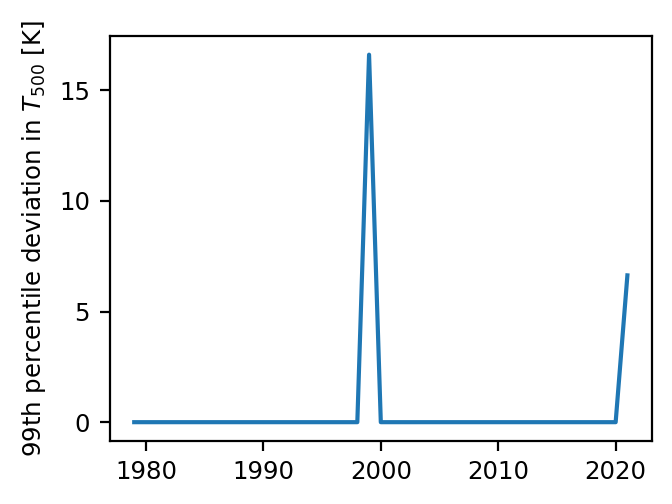

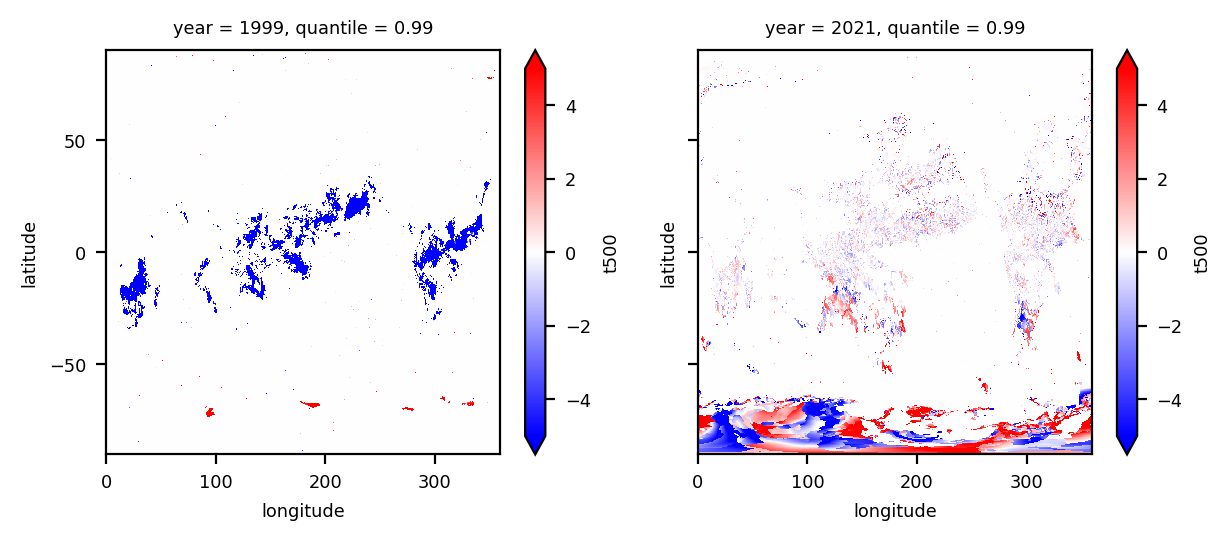

In [120]:
var_plot = 't500'
if var_plot == 't2m':
    var_diff = (t2m_max_zhang - t2m)
else:
    var_diff = (t500_zhang - t500)
var_diff_abs_max = np.abs(var_diff).quantile(0.99, dim=['longitude', 'latitude'])
fig, ax = plt.subplots(1, 1)
fig_resize(fig, 3.5)
ax.plot(var_diff.year, var_diff_abs_max)
ax.set_ylabel(f'99th percentile deviation in $T_{"{2m}" if var_plot=="t2m" else "{500}"}$ [K]')
update_fontsize(fig)

# Plot years with large deviation
years_plot = var_diff_abs_max > 1
n_plot = int(sum(years_plot))
if n_plot > 3:
    n_plot = 3
fig, ax = plt.subplots(1, n_plot, sharex=True, sharey=True)
if n_plot == 1:
    ax = [ax]
fig_resize(fig, 3.5*n_plot)
for i, year in enumerate(var_diff.year[years_plot]):
    var_diff.sel(year=year).plot(ax=ax[i], vmin=-5, vmax=5, cmap='bwr')
    if i >= n_plot - 1:
        break

update_fontsize(fig)
plt.show()

In [155]:
# Land masks
# The year for the land-sea mask matters. Not surprising due to glaciers melting. Zhang used 1979 mask.
lsm_zhang = xr.open_dataset('./Code_Zhang_Boos/e5.oper.invariant.128_172_lsm.ll025sc.1979010100_1979010100.nc').LSM.squeeze()
lsm = xr.open_dataset('../invariants/lsm1979.nc').lsm.squeeze()
# lsm = lsm_zhang
land = lsm.where(lsm>0.5)*0+1
ocean = lsm.where(lsm<=0.5)*0+1
weights = np.cos(np.deg2rad(land.latitude))

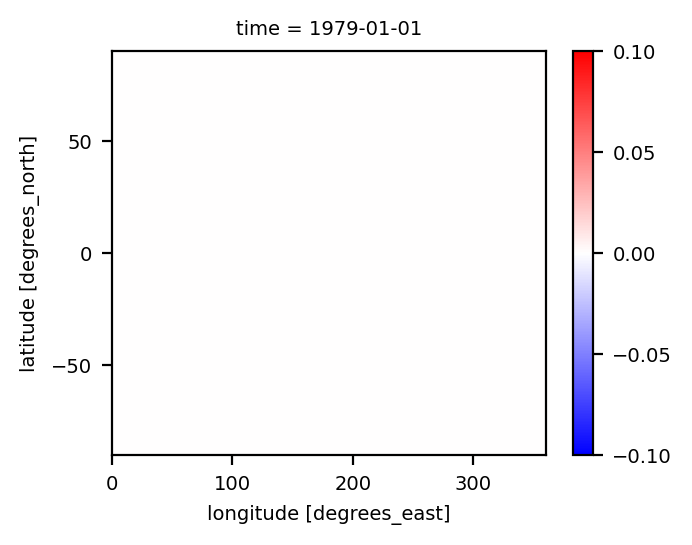

In [158]:
fig, ax = plt.subplots(1, 1)
fig_resize(fig, 3.5)
(lsm_zhang - lsm).plot(vmin=-0.1, vmax=0.1, cmap='bwr', ax=ax)
update_fontsize(fig)
plt.show()